## 1. 데이터 다운로드 

~/aiffel/lyricist/data/lyrics에 데이터가 있음

In [1]:
! mkdir -p ~/aiffel/lyricist/models
! ln -s ~/data ~/aiffel/lyricist/data

ln: failed to create symbolic link '/aiffel/aiffel/lyricist/data/data': Read-only file system


## 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이  
 glob 를 활용하여 모든 txt 파일을 읽어온 후,  
 raw_corpus 리스트에 문장 단위로 저장

In [20]:
#준비한 파일 내용 확인
import os, re
import numpy as np
import tensorflow as tf
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []


##### 데이터 확인해보기

In [21]:
#몇개의 파일이 있지?
print(f'The number of lyrics : {len(txt_list)}')

The number of lyrics : 49


In [22]:
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("문장 총 개수:", len(raw_corpus))
print("Examples:\n", raw_corpus[:30])

문장 총 개수: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'", "Somethin' ain't right when we talkin'", "Look like you hidin' your problems", 'Really you never was solid', 'No, you can\'t "son" me', "You won't never get to run me", 'Just when shit look out of reach', 'I reach back like one, three', 'Like one, three, yeah [Pre-Hook]', "That's when they smile in my face", 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Yeah, I know they wanna take my place', 'I can tell that love is fake', "I don't trust a word you say", 'How you wanna clique up after your mistakes?',

## 3. 데이터 정제

##### 1) 정제 함수 정의

In [23]:
#정제 함수 
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    #[] 부분은 훅이나 벌스같은 노래 부분 설명 단어라서 제외
    sentence = re.sub("\[.*\]*", " ", sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    #'아포스트로피도 축약, 소유격 표시등을 해주는 의미가 있어서 출력에 포함
    sentence = re.sub(r"[^a-z?.!,¿,']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

# 정제 결과 확인
print(preprocess_sentence(raw_corpus[1]))
print(preprocess_sentence(raw_corpus[13]))

<start> i've been down so long , it look like up to me <end>
<start> no , you can't son me <end>


##### 2) 함수로 정제된 문장 모으기

In [24]:
corpus = []

for sentence in raw_corpus:
    # 아무것도 없는 문장 건너뛰기
    if len(sentence) == 0: continue
        #건너뛰는 문장이 있는지 모르겠음 :이 데이터에 없는 것 같지만 
        #모든 데이터를 보지 못했기 때문에 혹시모를 확률에 대한 대비
    if (sentence.count(' ')+1 > 15) : continue
    if sentence[-1] == ")": continue
    if sentence[-1] == "]": continue
        
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인
print(len(corpus))
corpus[:10]

159742


["<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 '<start> straight up to my face , straight up to my face <end>',
 "<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> look like you hidin' your problems <end>"]

##### 3) 토큰화

In [25]:
#15개 이상의 토큰을 가지면 제거 
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞추기-> 시퀀스 길이 맞추려고
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    #문장 길이 설정 해주기
    #total_data_text = list(tensor)
    #num_tokens = [len(tokens) for tokens in total_data_text]
    #max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    #maxlen = int(max_tokens)
    #평균과 표준편차로 데이터 전체길이를 고려하여 적정 수준의 최대 길이 지정해줌
    #노드에서 지정해준 15개로 진행했지만  
    #노드 작성자의 의도가 왜 15개인지 모르지만, 해당 방법이 더 확장성 있다고 판단됨
    
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

#https://keras.io/ko/preprocessing/text/ : 토큰화 전처리

[[   2  145   99 ...   11    3    0]
 [   2   41  131 ...    0    0    0]
 [   2    6   34 ...    0    0    0]
 ...
 [   2   82  727 ...    0    0    0]
 [   2  213    3 ...    0    0    0]
 [   2    9 1409 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f5e3b2d7590>


In [26]:
#텐서 출력 해보기
print(tensor[:3])

#최대 15개까지만 토큰화된것 확인가능

[[   2  145   99   55   29  161    4   13  131   20   27   10   11    3
     0]
 [   2   41  131   27   10   11    3    0    0    0    0    0    0    0
     0]
 [   2    6   34  852  179 3086  852   36   10   11    3    0    0    0
     0]]


In [27]:
# tokenizer에 구축된 단어 사전의 인덱스 확인해보기

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [28]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 145  99  55  29 161   4  13 131  20  27  10  11   3]
[145  99  55  29 161   4  13 131  20  27  10  11   3   0]


## 4. 데이터셋 분리

##### 1) 데이터셋 정의

In [29]:
#데이터셋 객체 생성 -> 근데 학습할때 사용하지 않고, 그냥 분리한걸로만 했음
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

##### 2) 데이터셋 분리

In [30]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input, 
                                                    test_size = 0.2,
                                                    shuffle=True,
                                                    random_state=34)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

# 124960,15

Source Train: (127793, 14)
Target Train: (127793, 14)


##  5. 모델 생성, 학습

##### 1) 모델정의

In [31]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

##### 2) 모델_1 생성

In [32]:
embedding_size = 960
hidden_size = 2048  # 뱃사공
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.14055565e-05,  2.91396573e-04, -1.76139991e-04, ...,
          3.15354904e-04, -1.97258269e-04, -3.62575702e-05],
        [-3.10861033e-05, -2.39617657e-04, -2.61835725e-04, ...,
          7.14349371e-05, -2.49747798e-04, -1.43336700e-04],
        [-1.40092307e-04, -5.13346808e-04, -2.72612640e-04, ...,
         -1.52397421e-04,  4.11137327e-04, -8.94328579e-04],
        ...,
        [-1.85906736e-03, -1.02115481e-03, -1.36612833e-03, ...,
         -7.87769270e-04,  2.38773413e-03, -3.71370558e-03],
        [-1.92944414e-03, -9.93765425e-04, -9.30488051e-04, ...,
         -9.36758646e-04,  2.23756512e-03, -3.67717957e-03],
        [-2.02965736e-03, -1.28071662e-03, -8.71377066e-04, ...,
         -8.24997667e-04,  1.94570981e-03, -3.65443854e-03]],

       [[-1.14055565e-05,  2.91396573e-04, -1.76139991e-04, ...,
          3.15354904e-04, -1.97258269e-04, -3.62575702e-05],
        [-3.99958779e-04,  3.10352421e-04, -1

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  11520960  
_________________________________________________________________
lstm (LSTM)                  multiple                  24649728  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 94,323,361
Trainable params: 94,323,361
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


##### 3) 모델_1학습

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

hist = model.fit(enc_train, 
          dec_train, 
          epochs=10,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
500/500 [==============================] - 513s 1s/step - loss: 3.9208 - accuracy: 0.4493 - val_loss: 3.0478 - val_accuracy: 0.5082
Epoch 2/10
500/500 [==============================] - 512s 1s/step - loss: 2.9240 - accuracy: 0.5175 - val_loss: 2.7822 - val_accuracy: 0.5323
Epoch 3/10
500/500 [==============================] - 510s 1s/step - loss: 2.5916 - accuracy: 0.5441 - val_loss: 2.6002 - val_accuracy: 0.5539
Epoch 4/10
500/500 [==============================] - 507s 1s/step - loss: 2.2711 - accuracy: 0.5782 - val_loss: 2.4586 - val_accuracy: 0.5769
Epoch 5/10
500/500 [==============================] - 508s 1s/step - loss: 1.9565 - accuracy: 0.6221 - val_loss: 2.3574 - val_accuracy: 0.5983
Epoch 6/10
500/500 [==============================] - 506s 1s/step - loss: 1.6717 - accuracy: 0.6705 - val_loss: 2.2806 - val_accuracy: 0.6188
Epoch 7/10
500/500 [==============================] - 507s 1s/step - loss: 1.4161 - accuracy: 0.7198 - val_loss: 2.2420 - val_accuracy: 0.6355

## 6. 시각화

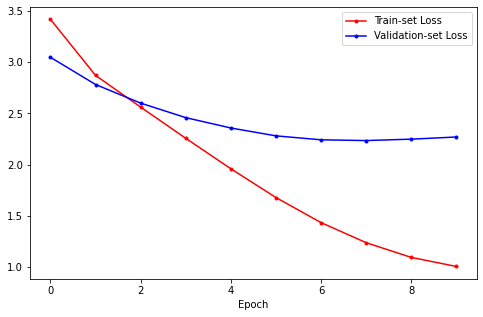

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(hist.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(hist.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#과적합 되고 있다고 판단 되어짐

## 7. 평가 : 문장생성 

In [47]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

#### 문장 결과가 모델 3와 같은데,,, 착각해서.. 두 아래 셀을 다시 실행해버려서 결과가 같게 나와버림..ㅠㅠㅠㅠㅠ
#### 즉 무시해야하는 결과가 됨 

In [48]:
print(generate_text(model, tokenizer, init_sentence="<start> i love"))
print(generate_text(model, tokenizer, init_sentence="<start> he makes"))
print(generate_text(model, tokenizer, init_sentence="<start> the girl"))
print(generate_text(model, tokenizer, init_sentence="<start> we"))

<start> i love you , i love you , i love you <end> 
<start> he makes me imagine it from bad to worse <end> 
<start> the girl under you guy i don't need to be on top <end> 
<start> we can do em in a minute then we finish with em <end> 


In [49]:
test_word = ['i love', 'i hate' ,'you', 'he', 'mine', 'my goal', 'coffee', 'sweet','i am','never']
result_dict1 = {}
for word in test_word:
    result1 = generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", word]))
    result_dict1[word] = result1
    print(result1)

<start> i love you , i love you , i love you <end> 
<start> i hate the way this feels <end> 
<start> you know you're right i'm so warm and calm inside <end> 
<start> he <unk> me beside the still waters . <end> 
<start> mine . <end> 
<start> my goal she was a hustler , <end> 
<start> coffee and tea <end> 
<start> sweet baby , hold your tears back now <end> 
<start> i am not throwing away my shot <end> 
<start> never felt like , felt like this before <end> 


### 모델_2

##### 데이터셋 정의   
데이터셋 객체 생성 해두고 학습시에 사용하지 않는 것 같아서  
이번엔 데이터셋 코드 수정해서 사용

In [12]:
#데이터셋 객체 생성
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256 
steps_per_epoch = len(src_input) // BATCH_SIZE
val_BUFFER_SIZE = len(enc_val)
# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset
val_dataset = val_dataset.shuffle(val_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

##### 모델 정의

In [17]:
#하이퍼파라미터 : embedding_size, hidden_size
embedding_size = 1600 #단어 하나당 특징=feature 수
hidden_size = 2048 #레이어의 노드수, 뱃사공 , 너무 많으면 산으로 간다
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

##### 모델 학습

In [18]:
hist= model.fit(dataset, 
        validation_data=val_dataset,
        epochs=10)
    
# 다시 loss가 올라가면서, 성능이 떨어지고 있음 

Epoch 1/10
499/499 [==============================] - 625s 1s/step - loss: 3.8955 - val_loss: 3.0717
Epoch 2/10
499/499 [==============================] - 596s 1s/step - loss: 2.9616 - val_loss: 2.8113
Epoch 3/10
499/499 [==============================] - 591s 1s/step - loss: 2.6278 - val_loss: 2.6332
Epoch 4/10
499/499 [==============================] - 577s 1s/step - loss: 2.3149 - val_loss: 2.4977
Epoch 5/10
499/499 [==============================] - 579s 1s/step - loss: 2.0222 - val_loss: 2.3964
Epoch 6/10
499/499 [==============================] - 586s 1s/step - loss: 1.7409 - val_loss: 2.3251
Epoch 7/10
499/499 [==============================] - 626s 1s/step - loss: 1.4965 - val_loss: 2.2775
Epoch 8/10
499/499 [==============================] - 560s 1s/step - loss: 1.3003 - val_loss: 2.2610
Epoch 9/10
499/499 [==============================] - 561s 1s/step - loss: 1.1479 - val_loss: 2.2655
Epoch 10/10
499/499 [==============================] - 560s 1s/step - loss: 1.0443 - val_lo

### 모델_3

##### 모델정의

In [ ]:
#하이퍼파라미터 : embedding_size, hidden_size
embedding_size = 1630 #단어 하나당 특징=feature 수
hidden_size = 2048 #레이어의 노드수, 뱃사공 , 너무 많으면 산으로 간다
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

##### 모델 학습

In [36]:
hist= model.fit(dataset, 
        validation_data=val_dataset,
        epochs=10)

#val_loss 가 확실히 감소했고, loss와 val_loss 모두 부드러운 곡선 형태로 하락하고 있음

Epoch 1/10
623/623 [==============================] - 715s 1s/step - loss: 1.7620 - val_loss: 1.4410
Epoch 2/10
623/623 [==============================] - 711s 1s/step - loss: 1.4604 - val_loss: 1.2071
Epoch 3/10
623/623 [==============================] - 710s 1s/step - loss: 1.2381 - val_loss: 1.0540
Epoch 4/10
623/623 [==============================] - 711s 1s/step - loss: 1.0888 - val_loss: 0.9645
Epoch 5/10
623/623 [==============================] - 712s 1s/step - loss: 1.0045 - val_loss: 0.9194
Epoch 6/10
623/623 [==============================] - 710s 1s/step - loss: 0.9639 - val_loss: 0.8983
Epoch 7/10
623/623 [==============================] - 712s 1s/step - loss: 0.9446 - val_loss: 0.8870
Epoch 8/10
623/623 [==============================] - 711s 1s/step - loss: 0.9340 - val_loss: 0.8833
Epoch 9/10
623/623 [==============================] - 710s 1s/step - loss: 0.9273 - val_loss: 0.8770
Epoch 10/10
623/623 [==============================] - 712s 1s/step - loss: 0.9219 - val_lo

## 6. 시각화 (생략)

### 7. 평가 : 문장 생성

In [39]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

generate_text(model, tokenizer, init_sentence="<start> he")

In [40]:
print(generate_text(model, tokenizer, init_sentence="<start> i love"))
print(generate_text(model, tokenizer, init_sentence="<start> he makes"))
print(generate_text(model, tokenizer, init_sentence="<start> the girl"))
print(generate_text(model, tokenizer, init_sentence="<start> we"))

<start> i love you , i love you , i love you <end> 
<start> he makes me imagine it from bad to worse <end> 
<start> the girl under you guy i don't need to be on top <end> 
<start> we can do em in a minute then we finish with em <end> 


In [44]:
test_word = ['i love', 'i hate' ,'you', 'he', 'mine', 'my goal', 'coffee', 'sweet','i am','never']
result_dict3 = {}
for word in test_word:
    result3 = generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", word]))
    result_dict3[word] = result3
    print(result)

<start> i love you , i love you , i love you <end> 
<start> i hate the way this feels <end> 
<start> you know you're right i'm so warm and calm inside <end> 
<start> he <unk> me beside the still waters . <end> 
<start> mine . <end> 
<start> my goal she was a hustler , <end> 
<start> coffee and tea <end> 
<start> sweet baby , hold your tears back now <end> 
<start> i am not throwing away my shot <end> 
<start> never felt like , felt like this before <end> 


In [46]:
# 모델_3 결과
import pandas as pd

pd.DataFrame(list(result_dict2.items()),
                   columns=['start', 'result'])

#다른 모델과 비교해보고 싶었는데, 그러지 못함.. 실수해서 결과값을 날려버림 ㅎ
#모델_3를 보자면, 같은 단어를 맞춰 쓰면서 라임을 생성하고 있다고 판단되어짐
#노래가사라서 문법이 안맞게 쓰이기도 했을 것이라 생각됨 

,start,result
0,i love,"<start> i love you , i love you , i love you <..."
1,i hate,<start> i hate the way this feels <end>
2,you,<start> you know you're right i'm so warm and ...
3,he,<start> he <unk> me beside the still waters . ...
4,mine,<start> mine . <end>
5,my goal,"<start> my goal she was a hustler , <end>"
6,coffee,<start> coffee and tea <end>
7,sweet,"<start> sweet baby , hold your tears back now ..."
8,i am,<start> i am not throwing away my shot <end>
9,never,"<start> never felt like , felt like this befor..."


## 8. 회고

### 💚누브릭 = 평가 지표
##### 1.텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?  
(정상적 텍스트 생성 모델)  
대부분의 하이퍼파라미터 조합의 결과,  
즉 대부분의 모델에서 생성된 문장들은  
**정상적 문장 생성으로 판단**  

근데 엄청난 단어길이와 라임 맞추는 결과,  
**비정상적 결과**가 나온적 있음  
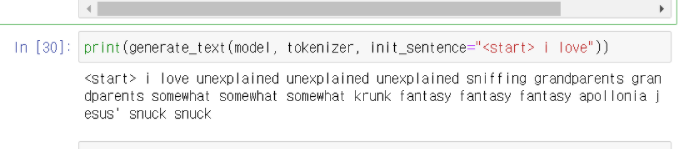 

val_loss가 내려가다가 다시 올라간것 말고는  
특이점이 없었는데,, 이유를 잘 모르겠음  
과적합이라고 판단이 되기는 하는데  
max_len =20 도 코드가 유효하지 않았음 (코드가 있었는데, 작동되지 않은듯)  

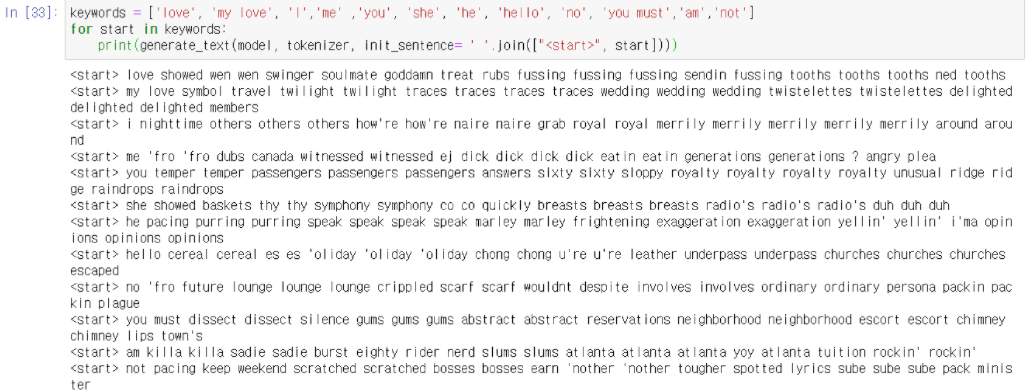
##### 2.특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?  
(데이터 전처리,구성과정이 체계적인가?)
>**1) 특수문자 제거**  
-> 노드에 제시된 전처리 후 소스데이터 개수 : 124960  
-> 내가 시도한 후 전처리 후 소스데이터 개수 : 127793  
비슷한 데이터 개수로 성공적이라고 판단 됨  
><br>
**2)아포스트로피 '**
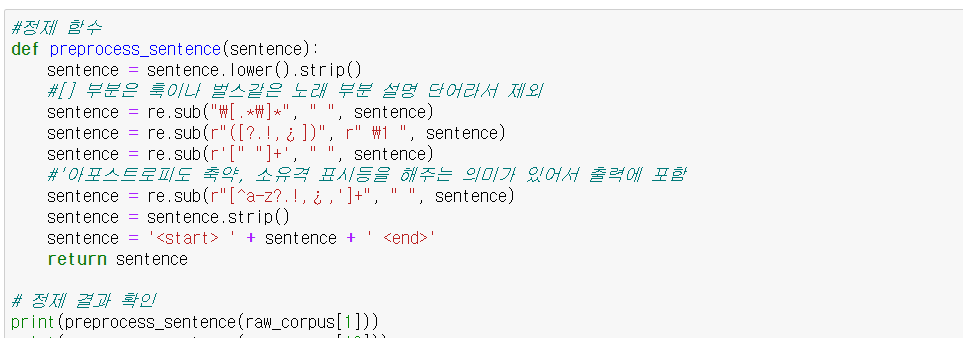
<br>
>정제 함수 정의하면서, 아포스트로피도 데이터에 포함시킴  
나는 모델 학습까지 다하고,  
문장 생성을 해보고 나서야 알게됨  
코드짤때 조금 더 다각화된 시각으로 기능을 만드는 것을 계속 연습해봐야함  
<br>
>**3)토크나이저 생성, 패딩처리**  
토큰화, 패딩 처리 완료  
패딩 처리하고난 후, 너무 긴 문장은 max_len=15로 최대 길이 15로 설정함  
노드에서 15라고 했는데,  
해당 부분에서 주석 달아놓은 것 처럼  
실제 데이터가 가지는 길이를 감안한 확장성 있는 코드가 더 좋다고 평가됨  
(해당 부분은 아래의 배운점에서 조금 더 언급)


##### 3.텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?  
(모델의 안정성)  
결국 마지막 모델에서  
했던 학습중에서 가장 loss 값이 낮은 결과가 나옴 !  

**val_loss 2.2 언저리 값이 나온 최근 시도들**  
>1  
BATCH_SIZE = 256  
embedding_size = 256  
hidden_size = 2048  
epochs=10  
에포크 9번째 결과 :  2.30  
<br>
>2  
BATCh_SIZE = 128  
embedding_size = 512  
hidden_size = 2048  
batch_size=512,  
epochs=10,  
에포크 10번째 결과 : 2.2576  
<br>
>3  
BATCH_SIZE = 256  
embedding_size = 800    
hidden_size = 2048  
10번째 에포크 : 2.24  
> 그밖에 기록하지 않은 결과들...n*n차,, ㅠ


### 그래서 😂하이퍼 파라미터 수정으로만 학습시키는 프로젝트 외에 양방향도 시도
'양방향 LSTM'이라는 이름의 두번째 프로젝트

### 💚어려웠던 점 
##### 1. 하이퍼파라미터
**기준없이, 직관적으로 하이퍼 파라미터를 지정**하고  
학습시키는 과정이 너무 힘들었음  
직관을 가지고 찍으면서, 인사이트를 얻으면서 개선시켜야 하는데,  
모델 학습 시간 자체도 너무 오래걸렸기 때문에 힘들었음  
그런데 하이퍼 파라미터 최적화 내용으로 cs231n과 E-06 노드에서  
**랜덤 서치** 개념을 배움  
(랜덤 서치 개념은 아래의 추후 시도할 점에서 더 언급)  
<br>
##### 2. val_loss =2.2  
loss 값의 의미를 잘 모르겠음  
노드에서 제대로된 평가지표가 없기때문에  
직접 문장을 생성해봐야한다고 함  
2점대의 loss 값 모두 생성된 문장 성능에 대해서는  
크게 눈에 띄게 다른 점이 없었음  
그런데 val_loss =2.2 이하로 낮추기가 굉장히 어려웠음  
이렇게까지 loss에 집착해야하는가에 대한 의문이 듦  

### 💚 배운점 
##### 1. 하이퍼파라미터
loss 값을 낮춰가면서 각각의 하이퍼 파라미터에 대한 개념에 대해  
명확하게 이해할 수 있었던 학습 경험이었음  

##### 2. ResourceExhaustedError
run 중에 계속 이따금 해당오류가 남  
에러 내용에 대해 알아보니  
GPU 메모리 할당 오류라고 함  
해결방법으로 GPU 할당량을 줄이기 위해 batch_size를 줄이도록 함  
그러나 줄여도 계속 오류가 나서보니  
클라우드상 run 되고 있는 문서가 많기 때문인것 같음  
running 파일 목록에서 셧다운을 하니 모델이 돌아감 

##### 3. 양방향 LSTM
해당 부분에 대한 회고 부분은  
양방향 LSTM 파일에 있음  

##### 3. 데이터 셋으로 학습  
위에서 두번째 모델 학습시에,  
데이터셋으로 학습 시킴  

### 💚개선점 = 나중에 더 시도해보고 싶은 것
**하이퍼파라미터 최적화, Bayeisan Optimization**  
~~우리가 고정한 random_state가  
cs231n 6강, lms EX6에서 배운 랜덤 서치인가 싶었음  
근데 우린 지금 텐서플로우 사용하고 있고...  
사이킷런 import 한적이 없음~~

~~만들고 싶은 모델에 따라 라이브러리가 달라질테고,  
라이브러리마다 이 하이퍼 파라미터에 대한 최적화가 달리 있는 것인가? 라는 생각이 들었다  
오늘 학습한 노드에 따르면 그리드 서치, 랜덤 서치는  
사이킷런 라이브러리에 있는 클래스였다~~

~~그렇다면, 현재 이 작사가 모델에는 텐서플로우를 사용하고 있으니까  
**우리가 고정한 random_state는 넘파이의 한 함수 기능일까..? 싶다** 
해당 내용을 서치해봤는데, 다 각각 다루는 자료만 있고  
해당 내용을 종합적으로 다루는 곳을 못찾았다.. 
피드백 받고나면 퍼실님께 질문을 드려야겠다~~

~~내 생각으론 그래서 지금 랜덤 스테이트 고정해서  
도출 결과값이 동일하게 나오도록 하고 있지만,  
이건 랜덤 서치 방법을 사용한 것이 아니라고 생각이 든다  
개념은 동일할지 몰라도 ?!~~

딥러닝에는 **랜덤서치, 그리드 서치** 등의  
하이퍼 파라미터 서치방법이 존재하고  
해당 방법들을 **각각의 라이브러리에서 저마다 다르게 지원**해줌!  
다른 분들께 질문하다가 깨달았는데,  
같이 공부하던 분들도 그렇게 얘기해주셔서 .. 맞는것 같음 ! ㅎㅎ  

하이퍼 파라미터에 대한 최적화가 너무 힘들어서 (어렵기보단 힘든게 더 맞음 ㅠㅠ)  
찾아보다가 **그리드서치, 랜덤 서치 외에 Bayeisan 최적화** 내용을 찾았다  
https://dacon.io/competitions/open/235698/talkboard/403915?page=1&dtype=recent 

해당 하이퍼파라미터 서치방법들로 작사가를 만들어보고 싶다 ..!  
특히 Bayeisan 최적화 부분은 꼭 배워서 해봐야겠다  
2021.7 자료니까,, 그래도 많이 쓰는 기능 아닐까 싶다  
하지만 해당 코드는 사이킷런으로 되어있지 않고,  
아무래도 작사가 프로젝트는 사이킷런이 아니라  
텐서플로우로 하는것이 더 합리적인 선택이기 때문이라고 생각이들어서  
다음에... 꼭 **하이퍼 파라미터 최적화를 사용해보고 싶다** ㅠ  
결국엔 범위를 점점 좁혀가는 사람의 수고로운 개입이 있어야하긴 하지만,,  
덜 번거로운 방법 이니까 ! 
(덜 거지같은 가중치를 찾는것이 가중치 최적화라고 하는 것 처럼ㅎ)

**생각하다보니 헷갈려서 정리하는 텐서플로우 vs 사이킷런**  
텐서플로우  
신경망이나 딥러닝을 위해 사용되는 데이터 계산, 연산을 위한 라이브러리며 신경망  
네트워크 레이어 정의를 위한 메서드도 제공  
하지만 결정 트리, 논리 회귀, K-Means, PCA와 같은 머신러닝 메서드는 제공하지 않는다.

사이킷런  
데이터 마이닝과 머신러닝을 위한 라이브러리  
딥러닝이나 강화 학습을 다루지 않지만 지도 학습, 비지도 학습에 관련된 다양한 메서드를 제공하기 때문에  
간단하게 학습 알고리즘을 사용하고자 한다면 사이킷런이 사용하기 쉽다는 장점
